# DQN - MountainCar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Setup environment

In [2]:
import gym
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\Christoph\Anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [4]:
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

## 2. DQN Implementation

In [11]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(2, num_hidden)
        self.l2 = nn.Linear(num_hidden, 3)
    
    def forward(self, x):
        out=self.l1(x)
        out=F.relu(out)
        out=self.l2(out)
        return out

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory = self.memory[1:]
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
            
    def __len__(self):
        return len(self.memory)
    
def get_epsilon(it, epsilon_goal=.05, max_steps=10000):
    epsilon = np.maximum(1 - (1-epsilon_goal)*((it)/max_steps), epsilon_goal)
    return epsilon

#def get_epsilon(it):
#    # YOUR CODE HERE
##     raise NotImplementedError
#    
#    epsilon =np.maximum(1+ - .95*((it)/1000),.05)
#    
#    return epsilon

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  
        Args:
            obs: current state
        Returns:
            An action (int).
            
        """
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.float)
            q = self.Q(obs)
            p = random.random()

            if p < self.epsilon:
                return int(len(q) * p/self.epsilon)
            else:
                return np.argmax(q).item()
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
        
def compute_q_vals(Q, states, actions):

    try:
        return torch.gather(Q.forward(states),1, actions)
    except:
        return Q_net.forward(state)[action].flatten()

def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """

    dones = dones.squeeze()
    ndmask = (1 - dones.type(torch.FloatTensor))
    
    targets= rewards.squeeze() + (discount_factor * torch.max(Q(next_states), 1)[0]) * ndmask.flatten()

    return targets.reshape(len(dones), 1)

def train(Q, memory, optimizer, batch_size, discount_factor,semi):
    loss_func = nn.MSELoss()
    
    if len(memory) < batch_size:
        return None
    
    transitions = memory.sample(batch_size)
    
    state, action, reward, next_state, done = zip(*transitions)

    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    q_val = compute_q_vals(Q, state, action)
    
    if semi==True:
        with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
            target = compute_targets(Q, reward, next_state, done, discount_factor)
    else:
        target = compute_targets(Q, reward, next_state, done, discount_factor)


    loss = loss_func(q_val, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi, epsilon_goal=.05):
    optimizer = optim.Adam(Q.parameters(), learn_rate)
      
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = [] 
    global_iter = 0
    for i in range(num_episodes):
        max_state=-.5
        state = env.reset()
        steps = 0
        while True:
            steps += 1
            epsilon = get_epsilon(global_steps, epsilon_goal=epsilon_goal, max_steps=num_episodes)
            policy.set_epsilon(epsilon)

            a = policy.sample_action(state)
            ns, reward, done, _ = env.step(a)
            
            if state[0]>max_state:
                max_state=state[0]
                reward=reward+0.5
            elif state[0]>0.5:
                reward=reward+10

            memory.push((state, a, reward, ns, done))

            train(Q, memory, optimizer, batch_size, discount_factor,semi)
    
            state = ns
            global_steps += 1

            if done:
                if state[0]>=.5:
                    epsilon=epsilon/10.
                if i % 10 == 0:
                    print(state)
                    print(reward)

                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append((steps,state[0]))
                break
    print(episode_durations)
  
    return episode_durations

In [12]:
# Let's run it!
num_episodes = 400
batch_size = 64
discount_factor = 0.999
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.3)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi=True)

[-0.51863871  0.00398738]
-1.0
 Episode 0 finished after 200 steps
[-0.30359326  0.00033822]
-0.5
 Episode 10 finished after 200 steps
[-0.39699543  0.0116279 ]
-1.0
 Episode 20 finished after 200 steps
[-0.02041824  0.024153  ]
-0.5
 Episode 30 finished after 200 steps
[-0.73043376  0.0076012 ]
-1.0
 Episode 40 finished after 200 steps
[-3.72212556e-01 -2.74225320e-04]
-1.0
 Episode 50 finished after 200 steps
[0.29557984 0.01952141]
-0.5
 Episode 60 finished after 200 steps
[-1.19627021  0.0024879 ]
-1.0
 Episode 70 finished after 200 steps
[-0.15548115 -0.04048546]
-1.0
 Episode 80 finished after 200 steps
[0.51382886 0.03605029]
-0.5
 Episode 90 finished after 157 steps
[-0.53183607 -0.00385855]
-1.0
 Episode 100 finished after 200 steps
[0.12695618 0.01788076]
-0.5
 Episode 110 finished after 200 steps
[-0.06882907  0.02799197]
-1.0
 Episode 120 finished after 200 steps
[-0.88082853  0.0410702 ]
-1.0
 Episode 130 finished after 200 steps
[-0.58103687 -0.00780422]
-1.0
 Episode 140

[(200, -0.518638713974334), (200, -0.5600402008090237), (200, -0.4579741151133072), (200, -0.35266134279160355), (200, -0.1839311011016398), (200, -0.4323670089215401), (200, 0.14771872489571847), (200, -0.2568964118742991), (200, -0.21103053554650714), (200, -0.1803360131873514), (200, -0.3035932571847593), (200, -0.3634284603726784), (200, -0.190733287784312), (200, -0.5724290684377218), (200, -0.5204366339374127), (200, -0.15519454064702934), (200, -0.12801379190094156), (200, -0.36910162558850673), (200, -0.38153270278366486), (200, -0.6719144144106702), (200, -0.3969954326767365), (200, -0.3427068858688025), (200, -0.6290068807022556), (200, -0.38998849846760664), (200, -0.4187369055564869), (200, -0.0021154729651708653), (200, -0.30745137128121314), (200, -0.5766226970372726), (200, -0.19681271069860906), (200, -0.7847881158288631), (200, -0.0204182377921214), (200, -0.22670099012142003), (200, -0.3096479817381991), (200, -0.23636230912532213), (200, -0.17641552616804798), (200, 

Text(0.5, 1.0, 'Episode durations per episode')

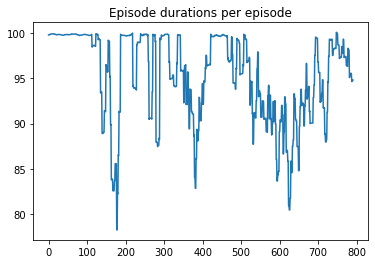

In [16]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

epi2 = [x[0] for x in episode_durations]
plt.plot(smooth(epi2, 10))
#plt.plot(smooth(episode_durations, 10))
#plt.plot(episode_durations)
plt.title('Episode durations per episode')

In [ ]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.00)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi=True)

In [55]:
import pandas as pd
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen#
results={}
results2={}
counter=0
import datetime as datetime
x=datetime.datetime.now()
for seed in range(10):
    for semib in [True,False]:
        for epsilon in [0.05]:
        #for epsilon in [0.0,.05]:
            for discount_factor in [.999]:
            #for discount_factor in [0.9,.99,1]:

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                env.seed(seed)

                Q_net = QNetwork(num_hidden)
                policy = EpsilonGreedyPolicy(Q_net, epsilon)
                episode_durations1 = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi=semib, epsilon_goal=epsilon)
                
                results[counter]={'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}
                results2[counter]={'DQN':Q_net,'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}

                counter=counter+1
    print(datetime.datetime.now()-x)
results11=pd.DataFrame(results).T
results11.to_hdf('resultsMC.h5','df')

[-0.41384685 -0.00569808]
-1.0
 Episode 0 finished after 200 steps
[-0.25951898 -0.01307525]
-1.0
 Episode 10 finished after 200 steps
[-0.49153104  0.00693184]
-1.0
 Episode 20 finished after 200 steps
[-0.65187122 -0.0150325 ]
-1.0
 Episode 30 finished after 200 steps
[0.18012775 0.01032282]
-0.5
 Episode 40 finished after 200 steps
[0.50058732 0.00913399]
-0.5
 Episode 50 finished after 161 steps
[-0.44847854  0.00501959]
-1.0
 Episode 60 finished after 200 steps
[ 0.24983397 -0.00384431]
-1.0
 Episode 70 finished after 200 steps
[-0.8433346  0.0120743]
-1.0
 Episode 80 finished after 200 steps
[-0.1773183   0.02443888]
-0.5
 Episode 90 finished after 200 steps
[0.06279871 0.00362931]
-0.5
 Episode 100 finished after 200 steps
[-0.11227952 -0.00059729]
-0.5
 Episode 110 finished after 200 steps
[-0.48398352 -0.01041089]
-1.0
 Episode 120 finished after 200 steps
[-0.35284582 -0.00447682]
-1.0
 Episode 130 finished after 200 steps
[-0.00857466 -0.00342588]
-1.0
 Episode 140 finished 

[(200, -0.41384685408119704), (200, -0.6794840851898765), (200, -0.4357869066037092), (200, -0.6945843773685811), (200, -0.5538754232502968), (200, -0.14058357651863979), (121, 0.5251574381595294), (200, -0.5508856719463806), (200, -0.1449373534328046), (200, -0.7171643636000126), (200, -0.25951898484781055), (200, -0.771435117632274), (200, -0.12040912237316861), (200, -0.4294399089488627), (200, -0.45098381255155906), (200, -0.08079785513327864), (200, -0.5679295918301178), (200, -0.36449206689025515), (200, -0.13354180611372077), (200, -0.42118562313802427), (200, -0.491531043716437), (200, -0.10702199295267639), (200, -0.2531670007830556), (200, -0.17236345295874728), (200, -0.5132791725938648), (200, -0.5331739458846964), (200, 0.11764909545038957), (200, -0.10383061724661136), (200, -0.2351698937370194), (200, -0.12396909466034389), (200, -0.6518712182564992), (200, 0.23646153667873382), (200, -0.29674938477455737), (200, -0.7755304571647366), (200, 0.04522746405162241), (200, -0

[-0.62520143 -0.0121391 ]
-1.0
 Episode 0 finished after 200 steps
[-0.71879913  0.00711813]
-1.0
 Episode 10 finished after 200 steps
[-0.85166549  0.0066361 ]
-1.0
 Episode 20 finished after 200 steps
[-0.68692189  0.00364244]
-1.0
 Episode 30 finished after 200 steps
[-0.80699834  0.0066288 ]
-1.0
 Episode 40 finished after 200 steps
[-7.53195013e-01  2.27221641e-04]
-1.0
 Episode 50 finished after 200 steps
[-0.81670328  0.00982045]
-1.0
 Episode 60 finished after 200 steps
[-0.74251157  0.00472521]
-1.0
 Episode 70 finished after 200 steps
[-0.66322308  0.00723346]
-1.0
 Episode 80 finished after 200 steps
[-0.78474612  0.00404846]
-1.0
 Episode 90 finished after 200 steps
[-0.71747781  0.00540138]
-1.0
 Episode 100 finished after 200 steps
[-0.68357573  0.00478021]
-1.0
 Episode 110 finished after 200 steps
[-0.78591524  0.00610546]
-1.0
 Episode 120 finished after 200 steps
[-0.74551598  0.00410749]
-1.0
 Episode 130 finished after 200 steps
[-0.84644427  0.00829169]
-1.0
 Episo

[(200, -0.625201426012649), (200, -0.6241385552532089), (200, -0.7259072542063253), (200, -0.6632928510621752), (200, -0.5955457116099986), (200, -0.8553788703737341), (200, -0.8025168866642838), (200, -0.8317548959081684), (200, -0.6630636335888628), (200, -0.7749383651430952), (200, -0.7187991276040866), (200, -0.8965562791529827), (200, -0.8387140372449008), (200, -0.9240015648635749), (200, -0.8773691480342443), (200, -0.847497307757043), (200, -0.7587662293901092), (200, -0.9047069589160546), (200, -0.7327087195153659), (200, -0.9711219390192113), (200, -0.8516654916323078), (200, -0.7668442420687642), (200, -0.6815374406595854), (200, -0.8208172199471533), (200, -0.768820876842985), (200, -0.8936907114494106), (200, -0.8798160525370987), (200, -0.6462865279602633), (200, -0.8182630215684877), (200, -0.735916377359904), (200, -0.686921894024963), (200, -0.7019356735315132), (200, -0.7335914449942631), (200, -0.8775310287028237), (200, -0.8018719076074919), (200, -0.778203875821024

0:14:24.260274
[-0.64657961  0.01682348]
-1.0
 Episode 0 finished after 200 steps
[-0.85162403  0.02205013]
-1.0
 Episode 10 finished after 200 steps
[-0.36365988 -0.00411052]
-1.0
 Episode 20 finished after 200 steps
[-0.40296669 -0.00177083]
-1.0
 Episode 30 finished after 200 steps
[-0.64497275  0.0140418 ]
-1.0
 Episode 40 finished after 200 steps
[-0.22094628  0.00065202]
-0.5
 Episode 50 finished after 200 steps
[-0.67929009  0.03415049]
-1.0
 Episode 60 finished after 200 steps
[-0.84688986  0.02156118]
-1.0
 Episode 70 finished after 200 steps
[-0.63120197 -0.0242803 ]
-1.0
 Episode 80 finished after 200 steps
[-0.3564726   0.01685369]
-1.0
 Episode 90 finished after 200 steps
[-0.56874089  0.03263301]
-1.0
 Episode 100 finished after 200 steps
[-0.93909958 -0.01746035]
-1.0
 Episode 110 finished after 200 steps
[-0.22638417  0.01013422]
-0.5
 Episode 120 finished after 200 steps
[-0.20973494 -0.02892078]
-1.0
 Episode 130 finished after 200 steps
[-0.03317641  0.00477457]
-0.5

[(200, -0.6465796085851938), (200, -0.5615929550563963), (200, -0.4466472658840646), (200, -0.49226371591136997), (200, -0.5338987905252405), (200, -0.00023486824320675947), (200, -0.2784813827570684), (200, -0.40435103783547705), (200, -0.4671542219149353), (200, -0.16383759006944604), (200, -0.8516240349137099), (200, -0.3762167429018138), (200, -0.6182825214288515), (200, -0.6488017113779588), (200, -0.06876583329942841), (200, -0.4634119974385652), (200, -0.49223242373703785), (200, -0.23806133858264097), (200, -0.08310310708240767), (200, -0.5412085274586884), (200, -0.36365988422415996), (200, 0.09713316696044907), (200, -0.36948657069476837), (200, -0.46586736395098693), (200, -0.2903635271568904), (200, -0.5869832145369211), (200, -0.3548678986279619), (200, -0.4151833137908629), (200, -0.3458436455462328), (200, -0.047228342546972876), (200, -0.402966685812802), (200, -0.6381047546460216), (200, -0.42242976485755984), (200, -0.6361312236828227), (200, -0.35944961338284187), (2

[-0.73690426  0.01685366]
-1.0
 Episode 0 finished after 200 steps
[-0.89257333  0.00706254]
-1.0
 Episode 10 finished after 200 steps
[-0.84334617  0.00565748]
-1.0
 Episode 20 finished after 200 steps
[-0.9380015   0.00141718]
-1.0
 Episode 30 finished after 200 steps
[-0.67057143  0.0034009 ]
-1.0
 Episode 40 finished after 200 steps
[-0.72684256  0.00851698]
-1.0
 Episode 50 finished after 200 steps
[-0.7510904  0.0045715]
-1.0
 Episode 60 finished after 200 steps
[-0.71779989  0.00180851]
-1.0
 Episode 70 finished after 200 steps
[-0.96609684 -0.00291003]
-1.0
 Episode 80 finished after 200 steps
[-0.68519499  0.00559382]
-1.0
 Episode 90 finished after 200 steps
[-0.83685031  0.00494541]
-1.0
 Episode 100 finished after 200 steps
[-0.71951337  0.01216494]
-1.0
 Episode 110 finished after 200 steps
[-0.89175314  0.00180503]
-1.0
 Episode 120 finished after 200 steps
[-0.7178902   0.00903838]
-1.0
 Episode 130 finished after 200 steps
[-0.86096156  0.00706756]
-1.0
 Episode 140 fin

[(200, -0.7369042644785153), (200, -0.7744927785388585), (200, -0.5585638251933096), (200, -0.6740107758474025), (200, -0.7305849502544735), (200, -0.703317508307845), (200, -0.7064354110796546), (200, -0.8140330529656767), (200, -0.8363447681711249), (200, -0.7691964618472306), (200, -0.8925733266692099), (200, -0.8196989263199566), (200, -0.6875819479658664), (200, -0.7366898296001719), (200, -0.9286071878470179), (200, -0.7472728060669287), (200, -0.7912430541371991), (200, -0.7931017390505137), (200, -0.8414815029306598), (200, -0.9304321320750222), (200, -0.843346166364352), (200, -0.7155138812880776), (200, -0.9274587545440205), (200, -0.8341951500127175), (200, -0.6898728104372217), (200, -0.8540402261915786), (200, -0.737686798958381), (200, -0.893107823255865), (200, -0.7785929104220779), (200, -0.8115225677204307), (200, -0.9380014987196346), (200, -0.810730338654529), (200, -0.7203691180303166), (200, -0.7415775558976231), (200, -0.7604797889998741), (200, -0.911712046059175

0:30:17.225436
[-0.55127703  0.0055704 ]
-1.0
 Episode 0 finished after 200 steps
[0.50920033 0.02274769]
-0.5
 Episode 10 finished after 154 steps
[-0.42465169  0.02321847]
-1.0
 Episode 20 finished after 200 steps
[-0.35269021  0.02737354]
-1.0
 Episode 30 finished after 200 steps
[-0.37868544 -0.00309397]
-1.0
 Episode 40 finished after 200 steps
[-0.97286424  0.02481731]
-1.0
 Episode 50 finished after 200 steps
[-0.3365776  -0.01905486]
-1.0
 Episode 60 finished after 200 steps
[-0.68188748 -0.03638176]
-1.0
 Episode 70 finished after 200 steps
[-0.97279909  0.0221238 ]
-1.0
 Episode 80 finished after 200 steps
[-0.71865027 -0.03515647]
-1.0
 Episode 90 finished after 200 steps
[-0.85108335 -0.02536833]
-1.0
 Episode 100 finished after 200 steps
[-0.17728631 -0.02825254]
-1.0
 Episode 110 finished after 200 steps
[-0.29743395 -0.01485457]
-1.0
 Episode 120 finished after 200 steps
[-0.90431774 -0.0052026 ]
-1.0
 Episode 130 finished after 200 steps
[-0.43016869 -0.00346296]
-1.0
 

[(200, -0.5512770329263517), (200, -0.3655178387172078), (200, -0.5893174619364526), (200, -0.806368044566754), (200, -0.9548225491455928), (200, -0.5203420575728067), (200, 0.14679684656612074), (200, -0.3086478947507353), (200, -0.7217380371462295), (200, -0.4246435369719768), (154, 0.5092003288330396), (200, -0.8158561768943303), (200, -0.358748757936633), (200, -0.19748162729169533), (200, -0.22965725600795123), (200, -0.49569430505369366), (200, -0.43265525432264906), (200, -1.0298248149244253), (200, 0.011158372804748377), (200, -0.5321739447208098), (200, -0.42465169435061), (200, -0.23394514424332535), (200, -0.021750283124787315), (200, -0.4133580780670577), (200, -0.5505629988292032), (200, -0.8460309984284528), (200, -0.8106960404507421), (200, -0.49323590742618834), (200, -0.7064887004640595), (200, -0.2506896091042339), (200, -0.35269021212161594), (200, -0.3854200900459229), (200, -1.0678769808404949), (200, -0.35853232176378497), (200, -0.26092498339778875), (200, -0.304

[-0.5916358  0.0077029]
-1.0
 Episode 0 finished after 200 steps
[-0.89859579  0.004647  ]
-1.0
 Episode 10 finished after 200 steps
[-0.90799021  0.00215418]
-1.0
 Episode 20 finished after 200 steps
[-0.89545328  0.00266582]
-1.0
 Episode 30 finished after 200 steps
[-0.88697623  0.00357616]
-1.0
 Episode 40 finished after 200 steps
[-0.69786317  0.00455626]
-1.0
 Episode 50 finished after 200 steps
[-7.59403797e-01 -1.26501406e-04]
-1.0
 Episode 60 finished after 200 steps
[-0.70426342  0.01024393]
-1.0
 Episode 70 finished after 200 steps
[-0.77223372  0.00961127]
-1.0
 Episode 80 finished after 200 steps
[-0.76468982  0.00248532]
-1.0
 Episode 90 finished after 200 steps
[-0.71134047  0.00766011]
-1.0
 Episode 100 finished after 200 steps
[-0.81413296  0.00824521]
-1.0
 Episode 110 finished after 200 steps
[-0.91044301  0.00446287]
-1.0
 Episode 120 finished after 200 steps
[-0.7400092   0.00945734]
-1.0
 Episode 130 finished after 200 steps
[-0.83420847  0.00948344]
-1.0
 Episode

[(200, -0.5916357961205877), (200, -0.47845567027778796), (200, -0.6403128080672326), (200, -0.6097930615247423), (200, -0.830764732516086), (200, -0.8122351001075191), (200, -0.699479417230937), (200, -0.7853669448373093), (200, -0.749582576120747), (200, -0.7786059178023053), (200, -0.8985957911472371), (200, -0.6917142607799779), (200, -0.7172048800556515), (200, -0.7081605136559244), (200, -0.8467732887236176), (200, -0.8702750070332842), (200, -0.8015547679200342), (200, -0.9189899492780436), (200, -0.7873850369410169), (200, -0.9743443291575195), (200, -0.9079902073843766), (200, -0.8559413579999027), (200, -0.7692530100204253), (200, -0.9074221382577691), (200, -0.7906108487410616), (200, -0.9878159821020068), (200, -0.8927655487428287), (200, -0.878552800356595), (200, -0.7208187580705403), (200, -0.7875974844089184), (200, -0.8954532848370014), (200, -0.850181234061343), (200, -0.8991962073102032), (200, -0.8791043585383137), (200, -0.8095509041696074), (200, -0.82857275501777

0:46:23.882569
[-0.52396271  0.02275253]
-1.0
 Episode 0 finished after 200 steps
[-0.20681083 -0.0106201 ]
-1.0
 Episode 10 finished after 200 steps
[-0.50713898 -0.01263873]
-1.0
 Episode 20 finished after 200 steps
[-0.02255126  0.03214159]
-0.5
 Episode 30 finished after 200 steps
[-0.34091179 -0.00856355]
-1.0
 Episode 40 finished after 200 steps
[-0.43128482  0.00284695]
-1.0
 Episode 50 finished after 200 steps
[-0.38389423 -0.01114843]
-1.0
 Episode 60 finished after 200 steps
[-0.46455387 -0.00172881]
-1.0
 Episode 70 finished after 200 steps
[-0.88889192  0.01419193]
-1.0
 Episode 80 finished after 200 steps
[-0.15357921 -0.02864997]
-1.0
 Episode 90 finished after 200 steps
[-0.16494989  0.01071979]
-0.5
 Episode 100 finished after 200 steps
[-0.50687898 -0.01344796]
-1.0
 Episode 110 finished after 200 steps
[-0.63164304 -0.018148  ]
-1.0
 Episode 120 finished after 200 steps
[-0.83321139 -0.01593234]
-1.0
 Episode 130 finished after 200 steps
[0.06724151 0.01097795]
-1.0
 

[(200, -0.5239627132443756), (200, -0.4394174447128644), (200, -0.6442852549888284), (200, -0.6709690533499988), (200, -0.7374898410437337), (200, -0.09164849284016585), (155, 0.5230514630972178), (200, -0.30089934487039044), (200, -0.16377202020127346), (200, -0.2735162768179726), (200, -0.20681083486672272), (200, -0.11473165661071022), (200, -0.3647777175760921), (200, -0.3445557075706473), (200, -0.46262269783674287), (200, -0.37787181533354164), (200, -0.4822717249368138), (200, -0.7219284345347127), (200, -0.4643550513992588), (200, -0.14750782429333667), (200, -0.5071389751678463), (200, -0.11805033339596804), (200, -0.3862365121693308), (200, -0.29311253161811884), (200, 0.08980435129450305), (200, -0.40939111387901156), (200, -0.127725429673857), (200, -0.4423018853409681), (200, -0.6014116162593387), (200, -0.4530756934031955), (200, -0.02255125889514989), (200, -0.5406800170385664), (200, -0.22173997891334346), (200, -0.4761102706753139), (200, -0.4383533438982904), (200, -0

[-0.52396271  0.02275253]
-1.0
 Episode 0 finished after 200 steps
[-0.52508179  0.01126622]
-1.0
 Episode 10 finished after 200 steps
[-0.51027345 -0.0060382 ]
-1.0
 Episode 20 finished after 200 steps
[-0.52041785 -0.00196177]
-1.0
 Episode 30 finished after 200 steps
[-0.52552803 -0.00325749]
-1.0
 Episode 40 finished after 200 steps
[-0.5375552  0.0128663]
-1.0
 Episode 50 finished after 200 steps
[-0.53343967 -0.00312571]
-1.0
 Episode 60 finished after 200 steps
[-0.52304612 -0.00387809]
-1.0
 Episode 70 finished after 200 steps
[-0.52666586  0.00325435]
-1.0
 Episode 80 finished after 200 steps
[-0.50492352  0.003024  ]
-1.0
 Episode 90 finished after 200 steps
[-4.72258637e-01  4.34415252e-04]
-1.0
 Episode 100 finished after 200 steps
[-0.52310258 -0.00343782]
-1.0
 Episode 110 finished after 200 steps
[-0.50277255  0.01008683]
-1.0
 Episode 120 finished after 200 steps
[-0.54161416 -0.00115184]
-1.0
 Episode 130 finished after 200 steps
[-0.54083505 -0.00228344]
-1.0
 Episode

[(200, -0.5239627132443756), (200, -0.5140381246476345), (200, -0.5045778149626949), (200, -0.5277383390075632), (200, -0.5084838913431746), (200, -0.5031553204620891), (200, -0.5271137659993802), (200, -0.5171805781705741), (200, -0.45021458963280064), (200, -0.5259954826670032), (200, -0.5250817859255994), (200, -0.5106458164813258), (200, -0.4744764549158879), (200, -0.5159916954958468), (200, -0.5099566297533472), (200, -0.5395609328138058), (200, -0.5585273089594684), (200, -0.5209105850131298), (200, -0.5083074404222928), (200, -0.5070877028385004), (200, -0.5102734513974314), (200, -0.5204933674253946), (200, -0.536341663533775), (200, -0.5182816622535636), (200, -0.5133627471649616), (200, -0.5239350721312176), (200, -0.5238862034868307), (200, -0.5270540293520866), (200, -0.49536653619585785), (200, -0.47727449520999976), (200, -0.5204178519002752), (200, -0.5291006935857447), (200, -0.5585851749262257), (200, -0.5506532949092889), (200, -0.5212636185240871), (200, -0.54388284

1:02:55.043717
[-0.40468336  0.02275998]
-1.0
 Episode 0 finished after 200 steps
[-0.55426048 -0.01343636]
-1.0
 Episode 10 finished after 200 steps
[-0.27161468  0.00159326]
-1.0
 Episode 20 finished after 200 steps
[0.33805457 0.0060152 ]
-0.5
 Episode 30 finished after 200 steps
[-0.37375525  0.01009776]
-1.0
 Episode 40 finished after 200 steps
[-0.51070462 -0.00108548]
-1.0
 Episode 50 finished after 200 steps
[-0.73183226 -0.01002125]
-1.0
 Episode 60 finished after 200 steps
[-0.96435251 -0.0047699 ]
-1.0
 Episode 70 finished after 200 steps
[-0.48850415 -0.01178236]
-1.0
 Episode 80 finished after 200 steps
[-0.15172205  0.01490687]
-0.5
 Episode 90 finished after 200 steps
[-0.59922621  0.0170182 ]
-1.0
 Episode 100 finished after 200 steps
[-0.67110717  0.00418289]
-1.0
 Episode 110 finished after 200 steps
[-0.56427365 -0.01524564]
-1.0
 Episode 120 finished after 200 steps
[-0.32940781  0.00870658]
-1.0
 Episode 130 finished after 200 steps
[-0.49404408 -0.02335285]
-1.0
 

[(200, -0.4046833610307708), (200, -0.5533919518474427), (200, -0.46596136601978316), (200, -0.3071671727492631), (200, -0.5089691203921214), (200, -0.3035997966302311), (200, -0.6069725523693934), (200, -0.2390876116308362), (200, -0.4665462787552906), (200, -0.5432096379480276), (200, -0.5542604843159925), (200, -0.29802744723260927), (200, -0.0704533752797856), (200, -0.3012510748430507), (200, -0.22397985198179693), (200, -0.24581074581227164), (200, -0.825520836869677), (200, 0.0022919326749414924), (200, -0.5036322321671562), (200, -0.3020471634345152), (200, -0.27161467575213993), (200, -0.270765606440419), (200, -0.17782495731604803), (200, -0.17319210010682176), (200, -0.4835938002153468), (200, 0.09125430873748348), (200, -0.6249746381671579), (200, -0.21984019485290782), (200, -0.3969122034667053), (200, -0.40998082958012994), (200, 0.3380545674520594), (200, -0.6295714871362389), (200, -0.1306377055975361), (200, -0.16547966380327814), (200, -0.6991842730892582), (200, -0.5

[-0.42710034  0.01810644]
-1.0
 Episode 0 finished after 200 steps
[-0.5466791   0.00723717]
-1.0
 Episode 10 finished after 200 steps
[-0.54026356 -0.00104923]
-1.0
 Episode 20 finished after 200 steps
[-0.52062586 -0.00664225]
-1.0
 Episode 30 finished after 200 steps
[-0.55239482  0.00150485]
-1.0
 Episode 40 finished after 200 steps
[-0.56312291 -0.00330753]
-1.0
 Episode 50 finished after 200 steps
[-0.51914724  0.01127858]
-1.0
 Episode 60 finished after 200 steps
[-0.53389247 -0.00758637]
-1.0
 Episode 70 finished after 200 steps
[-0.50723342 -0.0039296 ]
-1.0
 Episode 80 finished after 200 steps
[-0.54645308  0.00621255]
-1.0
 Episode 90 finished after 200 steps
[-0.50487231  0.00289997]
-1.0
 Episode 100 finished after 200 steps
[-0.51833164  0.0113189 ]
-1.0
 Episode 110 finished after 200 steps
[-0.53993042  0.00588955]
-1.0
 Episode 120 finished after 200 steps
[-0.54205493  0.01400526]
-1.0
 Episode 130 finished after 200 steps
[-0.50420656  0.00564018]
-1.0
 Episode 140 f

[(200, -0.42710034393894675), (200, -0.6146863510762056), (200, -0.443781437739437), (200, -0.46757298957908316), (200, -0.4523280968685037), (200, -0.5255091984367044), (200, -0.5282305026719791), (200, -0.5247831491779641), (200, -0.5067499696079235), (200, -0.5479917584477013), (200, -0.5466790984559167), (200, -0.5074547674303287), (200, -0.5408482486791841), (200, -0.5444926414712759), (200, -0.4887505864188846), (200, -0.5470358590917752), (200, -0.5541056060125417), (200, -0.5251054568401717), (200, -0.5206402730764847), (200, -0.5256371208198426), (200, -0.5402635630920996), (200, -0.5196018668204212), (200, -0.5148380884661149), (200, -0.5097513468401941), (200, -0.5001006495803577), (200, -0.5841516515393544), (200, -0.5126073416714212), (200, -0.5134041668133409), (200, -0.5221501299014517), (200, -0.5122969475663292), (200, -0.5206258630723883), (200, -0.5204695474184918), (200, -0.5762692996720487), (200, -0.5273994841705196), (200, -0.473605987511427), (200, -0.5245982799

1:18:44.667939
[-0.23807858  0.00960142]
-0.5
 Episode 0 finished after 200 steps
[-0.16841086 -0.0120648 ]
-1.0
 Episode 10 finished after 200 steps
[0.51409288 0.01548764]
-0.5
 Episode 20 finished after 145 steps
[-0.4898686   0.04742141]
-1.0
 Episode 30 finished after 200 steps
[-0.21045432  0.04518783]
-1.0
 Episode 40 finished after 200 steps
[0.51617504 0.04847483]
-0.5
 Episode 50 finished after 185 steps
[-0.40238897  0.05635753]
-1.0
 Episode 60 finished after 200 steps
[-5.45823952e-01 -1.20870174e-04]
-1.0
 Episode 70 finished after 200 steps
[-0.57780604  0.01316962]
-1.0
 Episode 80 finished after 200 steps
[-0.46954352 -0.02679453]
-1.0
 Episode 90 finished after 200 steps
[-0.32086696  0.01633182]
-0.5
 Episode 100 finished after 200 steps
[-0.57210568 -0.03686218]
-1.0
 Episode 110 finished after 200 steps
[-1.2  0. ]
-1.0
 Episode 120 finished after 200 steps
[-0.54232926  0.00468874]
-1.0
 Episode 130 finished after 200 steps
[-0.51104506  0.00435683]
-1.0
 Episode 

[(200, -0.2380785813134349), (200, -0.6230789592434217), (200, -0.3470038068876653), (200, -0.2665035453215131), (200, -0.2983304469303317), (200, -0.5063217766613104), (200, -0.04962882085688589), (200, -0.45020373078456427), (192, 0.5036824086811724), (200, -0.13853697490356895), (200, -0.16841085721977478), (200, 0.15239688062143386), (200, 0.06500296213376675), (200, -0.07379206045287415), (200, -0.426506746219202), (200, 0.4843925662792815), (200, -0.2993892424669025), (200, -0.8363393430321808), (200, -0.48776365216053713), (163, 0.5142819463539143), (145, 0.5140928761472596), (200, -0.8508557650513867), (200, 0.012806655303250113), (200, -0.8630933976257291), (200, -0.0636405068894999), (200, -0.34564021874052725), (200, -0.3144420867264461), (200, -0.36518671014992293), (200, 0.10614638736779103), (200, -0.2626740136058448), (200, -0.4898686030249279), (200, -0.18372096621567513), (200, -0.2953390402185104), (200, -0.32810459658767294), (200, -0.47429357876763417), (200, -0.405

[-0.31052011  0.00411924]
-0.5
 Episode 0 finished after 200 steps
[-0.55471837  0.00205411]
-1.0
 Episode 10 finished after 200 steps
[-0.5061822   0.00329399]
-1.0
 Episode 20 finished after 200 steps
[-0.53899039 -0.00456693]
-1.0
 Episode 30 finished after 200 steps
[-0.49178676 -0.00168568]
-1.0
 Episode 40 finished after 200 steps
[-0.51256334 -0.00244672]
-1.0
 Episode 50 finished after 200 steps
[-0.51310707 -0.00350971]
-1.0
 Episode 60 finished after 200 steps
[-5.53827870e-01 -8.03492595e-05]
-1.0
 Episode 70 finished after 200 steps
[-0.53475568  0.00699751]
-1.0
 Episode 80 finished after 200 steps
[-0.58382317  0.01351145]
-1.0
 Episode 90 finished after 200 steps
[-0.51258808  0.01057021]
-1.0
 Episode 100 finished after 200 steps
[-0.50324185  0.00996222]
-1.0
 Episode 110 finished after 200 steps
[-0.53854398  0.00643025]
-1.0
 Episode 120 finished after 200 steps
[-0.51555593  0.00451355]
-1.0
 Episode 130 finished after 200 steps
[-0.51592412 -0.00081479]
-1.0
 Episo

[(200, -0.3105201103996474), (200, -0.6136959818282759), (200, -0.5053092012486106), (200, -0.47551386499385134), (200, -0.5336196238553335), (200, -0.5235221582152733), (200, -0.5358766909800659), (200, -0.5152654950652134), (200, -0.5553386080989284), (200, -0.5145243161392739), (200, -0.5547183689471843), (200, -0.5273310423834723), (200, -0.5367316881913765), (200, -0.5524224985656878), (200, -0.5744700070743944), (200, -0.5146463528864901), (200, -0.5110035962688637), (200, -0.5068056274883074), (200, -0.5379315154872722), (200, -0.5261837408613265), (200, -0.5061822010391488), (200, -0.5209301879999453), (200, -0.520354977087851), (200, -0.4969169596857413), (200, -0.5279200009356404), (200, -0.5322785732724115), (200, -0.5176302862557707), (200, -0.5158034190704138), (200, -0.5476151842189468), (200, -0.5446330843786195), (200, -0.5389903875595193), (200, -0.523692469194923), (200, -0.4791735972643699), (200, -0.5655505270640683), (200, -0.5342914737444172), (200, -0.50619655081

1:34:34.499267
[-0.39286544 -0.00140781]
-1.0
 Episode 0 finished after 200 steps
[-0.77520432 -0.0025698 ]
-1.0
 Episode 10 finished after 200 steps
[-0.49150483  0.01490818]
-1.0
 Episode 20 finished after 200 steps
[-1.00329443 -0.02466341]
-1.0
 Episode 30 finished after 200 steps
[-0.55322258 -0.00812843]
-1.0
 Episode 40 finished after 200 steps
[-0.30401363 -0.01407924]
-1.0
 Episode 50 finished after 200 steps
[-0.50895967 -0.00834112]
-1.0
 Episode 60 finished after 200 steps
[-0.67947934  0.00978104]
-1.0
 Episode 70 finished after 200 steps
[-0.13957516 -0.0211329 ]
-1.0
 Episode 80 finished after 200 steps
[-9.11584745e-01  4.03796992e-04]
-1.0
 Episode 90 finished after 200 steps
[-0.73366329 -0.03264559]
-1.0
 Episode 100 finished after 200 steps
[-0.76466754  0.01470883]
-1.0
 Episode 110 finished after 200 steps
[-0.42483957 -0.0045183 ]
-1.0
 Episode 120 finished after 200 steps
[-0.624693  -0.0211334]
-1.0
 Episode 130 finished after 200 steps
[-0.05283887  0.01499996

[(200, -0.39286544242909316), (200, -0.6152191041746652), (200, -0.5089099655421078), (200, 0.027510846743324106), (200, -0.32332843830148256), (200, -1.0652525646390216), (200, 0.1683079793793455), (200, -0.6063603537841689), (200, 0.08055263485996879), (200, -0.7411232297440323), (200, -0.7752043175066226), (200, -0.33830463059797605), (200, -0.4179184370991608), (200, -0.3864068929244932), (200, -0.7112902712099114), (200, -1.0758048927741213), (200, -0.09132091000002336), (200, -0.5564034714908369), (200, -0.9487355730960612), (200, 0.3389480612288068), (200, -0.4915048326084082), (200, -0.5334313130374801), (200, -0.5676028897068313), (200, -0.9823907090723114), (200, -0.49240681954541016), (200, -0.350707511658241), (169, 0.5177382399450533), (200, -0.4985157063987425), (200, -0.392905617469514), (200, -0.5726169669265604), (200, -1.0032944252567195), (200, -0.388720924252728), (161, 0.5202652134140356), (200, -0.43689389052320987), (200, -0.12328192070650128), (200, -0.278463772

[-0.3885428  -0.00432772]
-1.0
 Episode 0 finished after 200 steps
[-0.1492762 -0.0058863]
-1.0
 Episode 10 finished after 200 steps
[-0.36778737  0.00260118]
-1.0
 Episode 20 finished after 200 steps
[-0.37281854 -0.00628606]
-1.0
 Episode 30 finished after 200 steps
[-0.76837162  0.00837807]
-1.0
 Episode 40 finished after 200 steps
[-0.72976743  0.00324556]
-1.0
 Episode 50 finished after 200 steps
[-0.85951632  0.00569553]
-1.0
 Episode 60 finished after 200 steps
[-0.86995614  0.00756415]
-1.0
 Episode 70 finished after 200 steps
[-0.7227377   0.00176482]
-1.0
 Episode 80 finished after 200 steps
[-0.73716079  0.00422461]
-1.0
 Episode 90 finished after 200 steps
[-0.93065544  0.00176486]
-1.0
 Episode 100 finished after 200 steps
[-0.76270686  0.00474455]
-1.0
 Episode 110 finished after 200 steps
[-0.79085795  0.00665308]
-1.0
 Episode 120 finished after 200 steps
[-9.25746268e-01  3.11461369e-04]
-1.0
 Episode 130 finished after 200 steps
[-0.81648517  0.00644546]
-1.0
 Episode

[(200, -0.38854280431355626), (200, -0.590022758243647), (200, -0.5089099655421078), (200, -0.17480636593362442), (200, -0.15451198174206313), (200, -0.36225660489275885), (200, -0.27584569650594615), (200, -0.20618240005695226), (200, -0.3642252918046207), (200, -0.3846671260825304), (200, -0.14927619902035827), (200, -0.38679435077282276), (200, -0.4179184370991608), (200, -0.3864068929244932), (200, -0.3702350102893576), (200, -0.3097635178476629), (200, -0.32430889913942856), (200, -0.3639076183269963), (200, -0.3416605618864377), (200, -0.4069931587070504), (200, -0.36778736557870356), (200, -0.1813127541490412), (200, -0.23740443531539399), (200, -0.17248785690502605), (200, -0.21128378161887423), (200, -0.3796819390549243), (200, -0.3731305077640859), (200, -0.18056554798344443), (200, -0.4099676769547025), (200, -0.2289209248735886), (200, -0.3728185396042361), (200, -0.28188805206015244), (200, -0.3641529868076989), (200, -0.6055751355716269), (200, -0.6626314558255341), (200,

1:49:40.931045
[-0.45223348  0.01198903]
-1.0
 Episode 0 finished after 200 steps
[-0.85393148 -0.02225881]
-1.0
 Episode 10 finished after 200 steps
[-0.60286212  0.00328914]
-1.0
 Episode 20 finished after 200 steps
[-0.11209015 -0.00970827]
-1.0
 Episode 30 finished after 200 steps
[-0.29159523 -0.00799861]
-1.0
 Episode 40 finished after 200 steps
[0.51536846 0.03030064]
-0.5
 Episode 50 finished after 182 steps
[-0.38209447 -0.02273186]
-1.0
 Episode 60 finished after 200 steps
[0.51660475 0.0396547 ]
-0.5
 Episode 70 finished after 139 steps
[0.50588756 0.03057299]
-0.5
 Episode 80 finished after 118 steps
[-0.51498483  0.00689801]
-1.0
 Episode 90 finished after 200 steps
[-0.42269769  0.03934158]
-1.0
 Episode 100 finished after 200 steps
[0.51085422 0.0396569 ]
-0.5
 Episode 110 finished after 177 steps
[-0.15201668 -0.00944689]
-1.0
 Episode 120 finished after 200 steps
[-0.50707975  0.00070337]
-1.0
 Episode 130 finished after 200 steps
[-0.56256443  0.00145595]
-1.0
 Episod

[(200, -0.4522334757634887), (200, -0.47788888113357253), (200, -0.4640242788517951), (200, -0.536820462233839), (200, -0.6206824346049278), (200, -0.5365439013481496), (200, -0.7972893425819405), (200, -0.5569253366504403), (200, -0.1820607762893948), (200, -0.5504719922743163), (200, -0.853931476424085), (200, -0.88568525384659), (200, -0.5921555656247642), (200, -0.7487368620854105), (200, -0.5103279807758045), (200, -0.6224119622831815), (200, -0.28276348256584727), (200, -0.7355727972814299), (200, -0.5056887625758077), (200, -0.8239419197906692), (200, -0.602862124896415), (200, -0.3395575061283608), (200, -0.7369418539162983), (200, -0.5523298698164891), (200, -0.9283677180618569), (200, -0.6641512811726029), (200, 0.0008842114316605504), (200, -0.24125679136863618), (200, -0.5815491307539993), (200, 0.03179232615163595), (200, -0.11209014691991613), (126, 0.5158598958001215), (192, 0.5238823500301276), (127, 0.5157423835580395), (200, -0.7094822015063902), (152, 0.5082918674188

[-0.49751505  0.00703111]
-1.0
 Episode 0 finished after 200 steps
[-0.77609729  0.00624895]
-1.0
 Episode 10 finished after 200 steps
[-0.82921937  0.00331889]
-1.0
 Episode 20 finished after 200 steps
[-0.77974964  0.00515047]
-1.0
 Episode 30 finished after 200 steps
[-0.73812067  0.00651585]
-1.0
 Episode 40 finished after 200 steps
[-0.77201442  0.00402649]
-1.0
 Episode 50 finished after 200 steps
[-0.73872926  0.0010019 ]
-1.0
 Episode 60 finished after 200 steps
[-0.73355569  0.00876782]
-1.0
 Episode 70 finished after 200 steps
[-0.68185041  0.00536662]
-1.0
 Episode 80 finished after 200 steps
[-0.77767611  0.00612646]
-1.0
 Episode 90 finished after 200 steps
[-0.82783606  0.0063748 ]
-1.0
 Episode 100 finished after 200 steps
[-0.93094511 -0.00181884]
-1.0
 Episode 110 finished after 200 steps
[-0.75740649  0.00490136]
-1.0
 Episode 120 finished after 200 steps
[-0.7561073   0.00733359]
-1.0
 Episode 130 finished after 200 steps
[-0.90921291  0.006623  ]
-1.0
 Episode 140 f

[(200, -0.49751504711401406), (200, -0.4770939993955972), (200, -0.6259505619258229), (200, -0.743003072660996), (200, -0.7572144644411828), (200, -0.7654880295594726), (200, -0.8590229143984466), (200, -0.735554705319465), (200, -0.7663827683541669), (200, -0.8422264383282734), (200, -0.7760972913848693), (200, -0.8921222261523225), (200, -0.808360210153242), (200, -0.7601966767083839), (200, -0.6819417381534117), (200, -0.9768554582891054), (200, -0.7124023771577969), (200, -0.8940937105218304), (200, -0.6740046926489024), (200, -0.7969699001005801), (200, -0.8292193704206572), (200, -0.6360408010382987), (200, -0.915013425017893), (200, -0.70660406981898), (200, -0.8126814549405916), (200, -0.7348617009140438), (200, -0.6460584435680067), (200, -0.7138557906615709), (200, -0.792728291270984), (200, -0.7533663160405021), (200, -0.7797496396960363), (200, -0.6584740865032933), (200, -0.7437677419637626), (200, -0.7437047206763835), (200, -0.709157340353105), (200, -0.834621866496057),

2:05:15.092297
[-0.45435026  0.00793754]
-1.0
 Episode 0 finished after 200 steps
[0.51436238 0.02396337]
-0.5
 Episode 10 finished after 180 steps
[-0.34115666  0.02592749]
-1.0
 Episode 20 finished after 200 steps
[-0.12209464  0.01002124]
-0.5
 Episode 30 finished after 200 steps
[-0.47518236 -0.01571382]
-1.0
 Episode 40 finished after 200 steps
[-1.00684233 -0.00626003]
-1.0
 Episode 50 finished after 200 steps
[-0.69675039  0.00510112]
-1.0
 Episode 60 finished after 200 steps
[-0.44726468 -0.01007763]
-1.0
 Episode 70 finished after 200 steps
[-0.59713228  0.0040261 ]
-1.0
 Episode 80 finished after 200 steps
[-0.22497707 -0.00547465]
-1.0
 Episode 90 finished after 200 steps
[-0.75270689 -0.02364856]
-1.0
 Episode 100 finished after 200 steps
[-0.77504383  0.01726693]
-1.0
 Episode 110 finished after 200 steps
[-0.07140143  0.02023823]
-0.5
 Episode 120 finished after 200 steps
[-0.52540739 -0.00417368]
-1.0
 Episode 130 finished after 200 steps
[-0.75990609  0.00790541]
-1.0
 

[(200, -0.4543502588275236), (200, -0.6284526735350296), (200, -0.448970433157783), (200, -0.33636806091253973), (200, -0.3898320392075415), (200, -0.4473339993493149), (200, -0.4521337196871958), (200, -0.7389750728776315), (200, -0.5941385231345674), (200, -0.5688872415571232), (180, 0.5143623806108165), (200, -0.3247746882429712), (200, -0.4160244056823764), (200, -0.40289522554829144), (200, -0.3921617853471409), (200, -0.5638390036032191), (200, -0.2631392852462803), (200, -0.5578503573556428), (200, -0.6055845836019395), (200, -0.6383078526338177), (200, -0.34115666257802385), (200, -0.29201306831807805), (200, -0.5606997058552526), (200, -0.4981107265181088), (200, -0.26252431096834067), (200, -0.5653307006993186), (200, -0.7234028624446472), (200, -0.45176950966434065), (200, -0.8007395338862205), (200, -0.3087963260812045), (200, -0.12209464153715854), (200, -0.5466379511939441), (200, -0.12762933085455574), (200, -0.32202845211493), (200, -0.7037631238941525), (200, -1.001543

[-0.45435026  0.00793754]
-1.0
 Episode 0 finished after 200 steps
[-0.52542478  0.0032179 ]
-1.0
 Episode 10 finished after 200 steps
[-0.50800619  0.0047061 ]
-1.0
 Episode 20 finished after 200 steps
[-0.48664871  0.00548532]
-1.0
 Episode 30 finished after 200 steps
[-0.56309477  0.00415799]
-1.0
 Episode 40 finished after 200 steps
[-0.51833255 -0.00773796]
-1.0
 Episode 50 finished after 200 steps
[-0.49848249  0.00377709]
-1.0
 Episode 60 finished after 200 steps
[-0.50596137  0.00345961]
-1.0
 Episode 70 finished after 200 steps
[-0.54506216  0.00710978]
-1.0
 Episode 80 finished after 200 steps
[-0.51396511 -0.00159054]
-1.0
 Episode 90 finished after 200 steps
[-0.55202322 -0.00245518]
-1.0
 Episode 100 finished after 200 steps
[-0.52195304  0.00256305]
-1.0
 Episode 110 finished after 200 steps
[-0.53005911 -0.00461689]
-1.0
 Episode 120 finished after 200 steps
[-0.52637222 -0.00056828]
-1.0
 Episode 130 finished after 200 steps
[-0.5263803  -0.00642222]
-1.0
 Episode 140 f

[(200, -0.4543502588275236), (200, -0.5692010371863581), (200, -0.5151019262321084), (200, -0.514947008744937), (200, -0.5214295453799683), (200, -0.5421183900980712), (200, -0.5296998851180982), (200, -0.5145204898959151), (200, -0.5325421455717889), (200, -0.49750565003299324), (200, -0.5254247752486564), (200, -0.509743378124874), (200, -0.5290612777043028), (200, -0.5627248596600146), (200, -0.525053698397129), (200, -0.5148979148028073), (200, -0.5379672616640058), (200, -0.5149174612333771), (200, -0.5202273473170613), (200, -0.5481497307129356), (200, -0.5080061921522291), (200, -0.528307688394085), (200, -0.5388548756249311), (200, -0.505078050263699), (200, -0.5231156381950899), (200, -0.5266289131212787), (200, -0.5244679726622025), (200, -0.5223071122135765), (200, -0.5550069251764205), (200, -0.5276391820508718), (200, -0.4866487056062158), (200, -0.5306682693274855), (200, -0.543415582341199), (200, -0.5066743636888186), (200, -0.5448034128598485), (200, -0.531664761498266

2:20:33.275861
[-0.53175705  0.00285598]
-1.0
 Episode 0 finished after 200 steps
[-0.35342709  0.01949665]
-1.0
 Episode 10 finished after 200 steps
[-0.32484831 -0.01383355]
-1.0
 Episode 20 finished after 200 steps
[-0.64433919  0.00821653]
-1.0
 Episode 30 finished after 200 steps
[-0.61000336  0.00287737]
-1.0
 Episode 40 finished after 200 steps
[-0.63935352 -0.01369438]
-1.0
 Episode 50 finished after 200 steps
[-0.53637223  0.00327772]
-1.0
 Episode 60 finished after 200 steps
[-0.4327976   0.01092727]
-1.0
 Episode 70 finished after 200 steps
[-0.49946243 -0.01045584]
-1.0
 Episode 80 finished after 200 steps
[-0.4484271   0.02762853]
-1.0
 Episode 90 finished after 200 steps
[-0.66782028 -0.01436214]
-1.0
 Episode 100 finished after 200 steps
[-0.51337815 -0.01647312]
-1.0
 Episode 110 finished after 200 steps
[-0.4144024  -0.00044354]
-1.0
 Episode 120 finished after 200 steps
[-0.48237456  0.01836386]
-1.0
 Episode 130 finished after 200 steps
[-0.73673297  0.01818628]
-1.0

[(200, -0.5317570454081557), (200, -0.5489273582576548), (200, -0.655706333992466), (200, -0.3359845972176965), (200, -0.4075713363588648), (200, -0.3847461853463794), (200, -0.6553178536584435), (200, -0.5676317900747266), (199, 0.532611588517742), (200, -0.9266480803832096), (200, -0.3534270878704552), (200, -0.6094930809772275), (200, -0.19877803034885336), (200, -0.3320310659491348), (200, -0.2975177464554573), (200, -0.8112021559829354), (200, -0.3706682888418668), (200, -0.4498455038525132), (200, -0.4087108336686407), (200, 0.40483841550846944), (200, -0.324848313009107), (200, -0.567560562179009), (200, -0.7729267408983991), (200, -0.6952009956622133), (200, -0.2615168474650562), (200, -0.3394502096573269), (200, -0.6600507599883456), (200, -0.6317639515546021), (200, -0.512764911366434), (200, -0.7536443528950246), (200, -0.6443391904680142), (200, -0.5275059937210228), (200, -0.5071408023138717), (200, -0.5701145580020275), (200, -0.39310796602699705), (200, -0.38027630431097

[-0.53175705  0.00285598]
-1.0
 Episode 0 finished after 200 steps
[-0.64023255  0.00773059]
-1.0
 Episode 10 finished after 200 steps
[-0.78416026  0.00692701]
-1.0
 Episode 20 finished after 200 steps
[-0.71330093  0.01154268]
-1.0
 Episode 30 finished after 200 steps
[-0.7074495   0.00464626]
-1.0
 Episode 40 finished after 200 steps
[-0.85831591  0.00744239]
-1.0
 Episode 50 finished after 200 steps
[-0.80641617  0.00734221]
-1.0
 Episode 60 finished after 200 steps
[-0.76826288  0.0078268 ]
-1.0
 Episode 70 finished after 200 steps
[-0.73006202  0.00790092]
-1.0
 Episode 80 finished after 200 steps
[-0.87745127  0.00872959]
-1.0
 Episode 90 finished after 200 steps
[-0.88408465  0.00542304]
-1.0
 Episode 100 finished after 200 steps
[-0.82254905  0.00478782]
-1.0
 Episode 110 finished after 200 steps
[-0.73378768  0.0029919 ]
-1.0
 Episode 120 finished after 200 steps
[-0.70978256  0.00808556]
-1.0
 Episode 130 finished after 200 steps
[-0.71951054  0.0102324 ]
-1.0
 Episode 140 f

[(200, -0.5317570454081557), (200, -0.5689535103849388), (200, -0.5278398071801835), (200, -0.7135989161665406), (200, -0.9200004932862499), (200, -0.8140330839103007), (200, -0.757618590506619), (200, -0.8215520771754581), (200, -0.7442662448757751), (200, -0.7490173950601714), (200, -0.6402325542209633), (200, -0.8484799879237467), (200, -0.8274904712271927), (200, -0.9022296805485428), (200, -0.7887287999019338), (200, -0.8918765291379264), (200, -0.7244940837050373), (200, -0.7910270636646698), (200, -0.7639945848290206), (200, -0.77377152480314), (200, -0.7841602573922125), (200, -0.860668636127976), (200, -0.7019606937856954), (200, -0.7052963881290379), (200, -0.7085098758423912), (200, -0.6915751972623334), (200, -0.8343587743734403), (200, -0.7654700649514037), (200, -0.7057961187132412), (200, -0.8027870873450028), (200, -0.7133009325252878), (200, -0.8365235041815856), (200, -0.7621762195020513), (200, -0.6430799821120371), (200, -0.8303478091277791), (200, -0.73482712225933

2:35:58.027843


C:\Users\Christoph\Anaconda3\envs\rl2020\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['EpisodeDuration', 'Seed', 'SemiB', 'Epsilon', 'DisFactor'], dtype='object')]

  encoding=encoding,


In [56]:
results2_df=pd.DataFrame(results2).T
results2_df.to_hdf('results2.h5','df')

C:\Users\Christoph\Anaconda3\envs\rl2020\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['DQN', 'EpisodeDuration', 'Seed', 'SemiB', 'Epsilon', 'DisFactor'], dtype='object')]

  encoding=encoding,


In [57]:
results11=pd.DataFrame(results).T
[x for x in [x for x in results11['EpisodeDuration']]]

[[(200, -0.41384685408119704),
  (200, -0.6794840851898765),
  (200, -0.4357869066037092),
  (200, -0.6945843773685811),
  (200, -0.5538754232502968),
  (200, -0.14058357651863979),
  (121, 0.5251574381595294),
  (200, -0.5508856719463806),
  (200, -0.1449373534328046),
  (200, -0.7171643636000126),
  (200, -0.25951898484781055),
  (200, -0.771435117632274),
  (200, -0.12040912237316861),
  (200, -0.4294399089488627),
  (200, -0.45098381255155906),
  (200, -0.08079785513327864),
  (200, -0.5679295918301178),
  (200, -0.36449206689025515),
  (200, -0.13354180611372077),
  (200, -0.42118562313802427),
  (200, -0.491531043716437),
  (200, -0.10702199295267639),
  (200, -0.2531670007830556),
  (200, -0.17236345295874728),
  (200, -0.5132791725938648),
  (200, -0.5331739458846964),
  (200, 0.11764909545038957),
  (200, -0.10383061724661136),
  (200, -0.2351698937370194),
  (200, -0.12396909466034389),
  (200, -0.6518712182564992),
  (200, 0.23646153667873382),
  (200, -0.29674938477455737),

In [24]:
results['FinalStatePerEpisodde']

KeyError: 'FinalStatePerEpisodde'

In [58]:
results11['FinalState']=[x[-1][1] for x in results11['EpisodeDuration']]
results11['episodes']=[x[-1][0] for x in results11['EpisodeDuration']]

In [59]:
results11.groupby(['SemiB','Epsilon','DisFactor'])['FinalState','EpisodeDuration'].mean().reset_index().sort_values('FinalState',ascending=False)

C:\Users\Christoph\Anaconda3\envs\rl2020\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,SemiB,Epsilon,DisFactor,FinalState
1,True,0.05,0.999,0.052184
0,False,0.05,0.999,-0.678904


In [66]:
GDQN = aa.loc[aa['SemiB']==True].sort_values('FinalState').tail(1)['DQN'].values[0]

In [67]:
GDQN = aa.sort_values('FinalState').tail(1)['DQN'].values[0]
GDQN = aa.sort_values('FinalState').tail(1)['DQN'].values[0]

In [60]:
aa=pd.DataFrame(results2).T
aa['FinalState']=[x[-1][1] for x in aa['EpisodeDuration']]
aa['episodes']=[x[-1][0] for x in aa['EpisodeDuration']]

In [68]:
from torch.autograd import Variable

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, temp = torch.max(GDQN(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

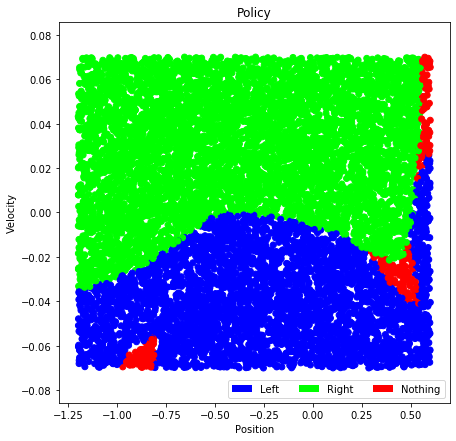

In [69]:
# reference for plot https://medium.com/@ts1829/solving-mountain-car-with-q-learning-b77bf71b1de2
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - FullG.png')
plt.show()

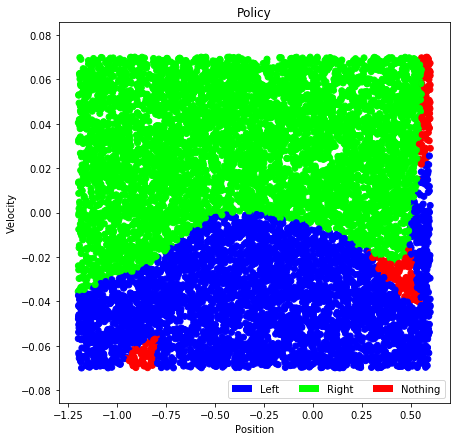

In [65]:

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - SemiG.png')
plt.show()

In [116]:
results11.groupby(['SemiB','Epsilon','DisFactor'])['FinalState'].max().reset_index().sort_values('FinalState',ascending=False)

,SemiB,Epsilon,DisFactor,FinalState
14,True,0.00,1.0,0.545409
20,True,0.05,1.0,0.532265
23,True,0.30,1.0,0.525684
17,True,0.01,1.0,0.513890
1,False,0.00,0.8,0.093655
15,True,0.01,0.5,0.052143
21,True,0.30,0.5,-0.086201
12,True,0.00,0.5,-0.091090
18,True,0.05,0.5,-0.126276
10,False,0.30,0.8,-0.175895


In [9]:
results11.to_hdf('blah.h5','df')

NameError: name 'results11' is not defined

## Plot Results ##

In [83]:
display(results_df)

results_df.groupby(['SemiB','Epsilon','DisFactor'])['FinalState','EpisodeDuration'].mean().reset_index().sort_values('EpisodeDuration',ascending=False)


,EpisodeDuration,Seed,SemiB,Epsilon,DisFactor
0,"[(200, -0.41384685408119704), (200, -0.6794840...",0,True,0.05,0.999
1,"[(200, -0.625201426012649), (200, -0.624138555...",0,False,0.05,0.999
2,"[(200, -0.6465796085851938), (200, -0.56159295...",1,True,0.05,0.999
3,"[(200, -0.7369042644785153), (200, -0.77449277...",1,False,0.05,0.999
4,"[(200, -0.5512770329263517), (200, -0.36551783...",2,True,0.05,0.999
5,"[(200, -0.5916357961205877), (200, -0.47845567...",2,False,0.05,0.999
6,"[(200, -0.5239627132443756), (200, -0.43941744...",3,True,0.05,0.999
7,"[(200, -0.5239627132443756), (200, -0.51403812...",3,False,0.05,0.999
8,"[(200, -0.4046833610307708), (200, -0.55339195...",4,True,0.05,0.999
9,"[(200, -0.42710034393894675), (200, -0.6146863...",4,False,0.05,0.999


C:\Users\Christoph\Anaconda3\envs\rl2020\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: "Columns not found: 'FinalState'"

(10, 1000)
(10, 1000)


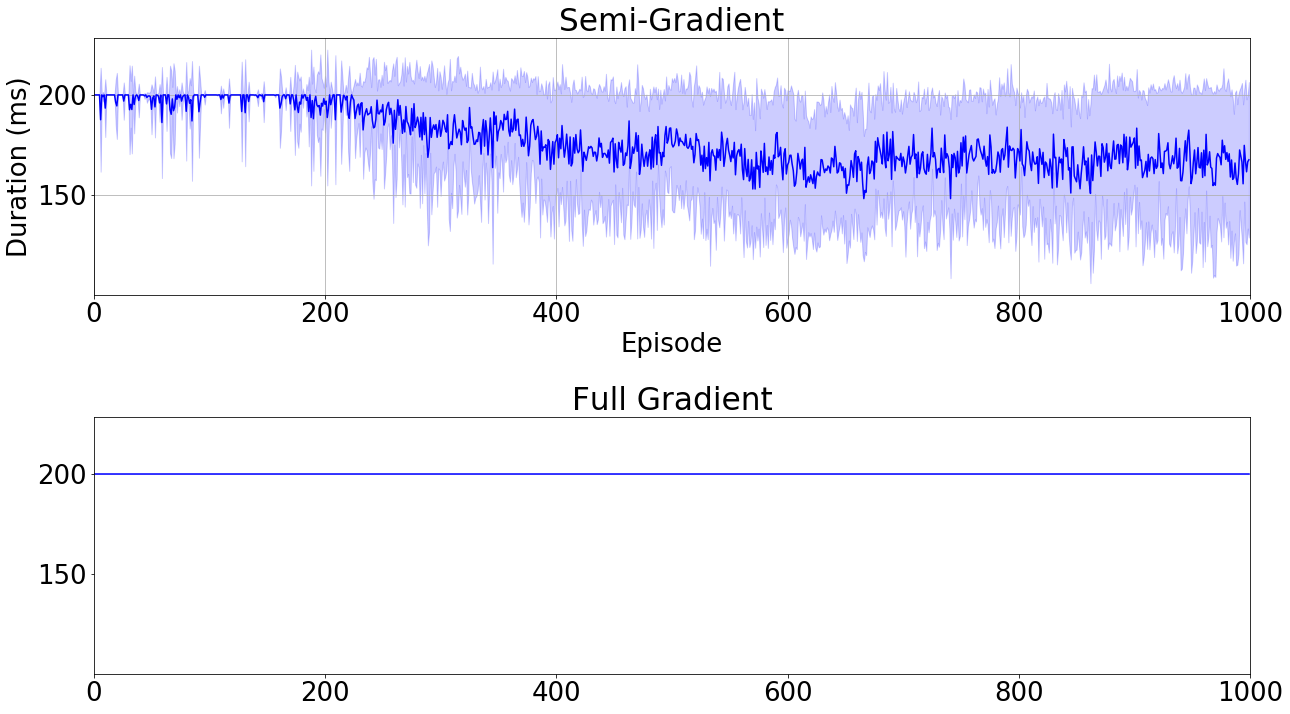

In [115]:
files = ['resultsMC.h5']#, 'results2.h5']
n = 0
fig, axs = plt.subplots(2, sharey=True)
results_df = pd.read_hdf(file)

for semi in [True,False]:
    method_df = results_df.loc[results_df['SemiB']==semi]
    #if results_df.shape[0] != 10:
    #    results_df = results_df.loc[10:, :]
    #    results_df.reset_index(drop=True, inplace=True)
    tmp = []
    for i in range(10):
        durations_only = [tup[0] for tup in list(method_df.loc[results_df['Seed']==i, 'EpisodeDuration'])[0]]
        tmp.append(durations_only)
    durations_np = np.array(tmp)
    print(durations_np.shape)
    #mean = durations_np[0, :]
    mean = durations_np.mean(axis=0)
    std = durations_np.std(axis=0)
    plt.rcParams.update({'font.size': 26})

    axs[n].plot(range(len(mean)), mean, '-', color='blue')

    axs[n].fill_between(range(len(mean)), mean-std, mean+std,
                     color='blue', alpha=0.2)
    if n == 0:
        axs[n].set_title('Semi-Gradient')
    else:
        axs[n].set_title('Full Gradient')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Duration (ms)')
    axs[0].grid(True)
    axs[n].set_xlim([0, 1000])
    #plt.xlabel('Episodes')
    #plt.ylabel('Duration (ms)')
    #plt.title('Semi-gradient Performance on Cart Pole\n(Mean and Std)')
    n += 1
#plt.grid()
#axs[1].grid()
#axs[1].grid()

fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.savefig('cart_pole_semi.pdf', bbox_inches='tight')
#plt.show()

NameError: name 'mean' is not defined